<a href="https://colab.research.google.com/github/nayanikab20/ML-algorithms/blob/main/LDA_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# loading dataset into a dataframe

wine=load_wine()

X = pd.DataFrame(wine.data, columns=wine.feature_names)
Y = pd.Categorical.from_codes(wine.target, wine.target_names)

In [ ]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [ ]:
def within_class_scatter_matrix(df, feature_n, class_feature_means):
  """Calculate sum of within class covariances of all classes
  """
  within_class_scatter_matrix=np.zeros((feature_n,feature_n))

  for classes, rows in df.groupby('Class'):
    rows=rows.drop(['Class'], axis=1) 
    s = np.zeros((feature_n,feature_n))

    for index, row in rows.iterrows():
      x, mc = row.values.reshape(feature_n,1), class_feature_means[classes].values.reshape(feature_n,1)
        
      s += (x - mc).dot((x - mc).T)
      assert s.shape == (feature_n,feature_n)
    
      within_class_scatter_matrix += s

  return within_class_scatter_matrix

In [ ]:
def between_class_scatter_matrix(df, feature_n, class_feature_means):
  """ Calculate scatter matrix between all classes
  """

  feature_means = df.mean()
  between_class_scatter_matrix = np.zeros((feature_n,feature_n))
  for c in class_feature_means:    
    n = len(df.loc[df['Class'] == c].index)
    
    mc, m = class_feature_means[c].values.reshape(feature_n,1), feature_means.values.reshape(feature_n,1)
    
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

  return between_class_scatter_matrix

In [ ]:
def LDA(df):
  """ This function performs the linear discriminant analysis of the dataset
  
  Args:
    df(Dataframe): dataset with features and labels
    Sw(NxN matrix): sum of within class scatter matrices
    Sb(NxN matrix): inter-class scatter matrix

  Return:
    eigenvectors(N Nx1 vectors): LDA components(Eigenvectors)
    eigenvalues(1D array): corresponding eigenvalues
  """

  # calculating the classwise mean of every feature
  class_feature_means = pd.DataFrame(columns=wine.target_names)
  for c, rows in df.groupby('Class'):
    class_feature_means[c] = rows.mean()

  feature_n = len(df.columns) - 1 # excluding class
  assert feature_n == 13

  Sw = within_class_scatter_matrix(df, feature_n, class_feature_means)
  Sb = between_class_scatter_matrix(df, feature_n, class_feature_means)
  
  # calculating the eigenvectors(LDA components) and corresponding eigenvalues
  eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

  return eigenvalues, eigenvectors

In [ ]:
# splitting data into test and train set - 30 - 70 split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

df_train=X_train.join(pd.Series(Y_train, name='Class')) # joining data and labels

#df=X.join(pd.Series(Y, name='Class')) # joining data and labels

eigen_values, eigen_vectors = LDA(df_train)

pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)


eigen_value_sums = sum(eigen_values)
print('Explained Varience by each eigenvector ')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

# choosing 2 most significant eigenvectors
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real
print('The 2 eigenvectors are :{}',format(w_matrix))

X_lda = np.array(X_train.dot(w_matrix)) # projecting samples to new bases

le = LabelEncoder()
Y_train_code = le.fit_transform(Y_train)


Explained Varience by each eigenvector 
Eigenvector 0: 0.7854973284936229
Eigenvector 1: 0.15631993406322234
Eigenvector 2: 0.05818273744315455
Eigenvector 3: 2.582181694561556e-16
Eigenvector 4: 7.646458339170955e-17
Eigenvector 5: 7.05282282850315e-17
Eigenvector 6: 7.05282282850315e-17
Eigenvector 7: 4.245615453935202e-17
Eigenvector 8: 3.011696488708614e-17
Eigenvector 9: 1.88458034000574e-17
Eigenvector 10: 1.766515637192773e-17
Eigenvector 11: 1.766515637192773e-17
Eigenvector 12: 3.2220606380815288e-18
The 2 eigenvectors are :{} [[ 5.36444238e-02  8.78719102e-02]
 [ 3.69021134e-02  3.99153553e-02]
 [ 7.86858267e-02  4.54832353e-01]
 [ 2.65716281e-02 -2.84144762e-02]
 [-3.23123426e-03 -1.91514998e-03]
 [ 2.48380559e-01  7.89919713e-02]
 [-6.87879921e-01  2.51132898e-02]
 [-4.25883445e-01 -6.93645488e-01]
 [ 3.56328147e-01 -1.44818251e-01]
 [ 3.62321239e-01 -4.66096146e-02]
 [ 9.97609252e-02  4.64281637e-01]
 [ 6.63679075e-02 -2.37244049e-01]
 [-8.89387562e-04 -5.83832846e-04]]


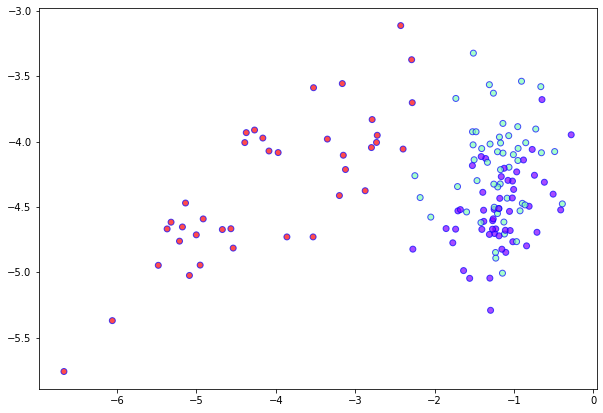

In [ ]:
figure=plt.figure(figsize=(10,7))
ax=plt.axes(projection=None)
ax.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=Y_train_code,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

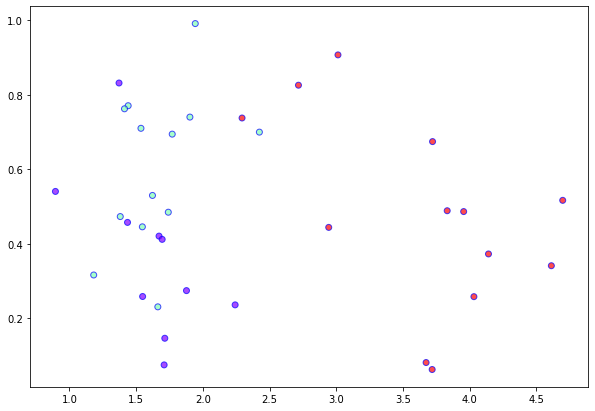

In [ ]:
# testing

X_test_lda = np.array(X_test.dot(w_matrix))

Y_test_code = le.fit_transform(Y_test)

figure=plt.figure(figsize=(10,7))
ax=plt.axes(projection=None)
ax.scatter(
    X_test_lda[:,0],
    X_test_lda[:,1],
    c=Y_test_code,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [ ]:
# clustering using K means

kmeans = KMeans(n_clusters=3,init='random')
kmeans.fit(X_test_lda)
KMeans_Y = kmeans.predict(X_test_lda)

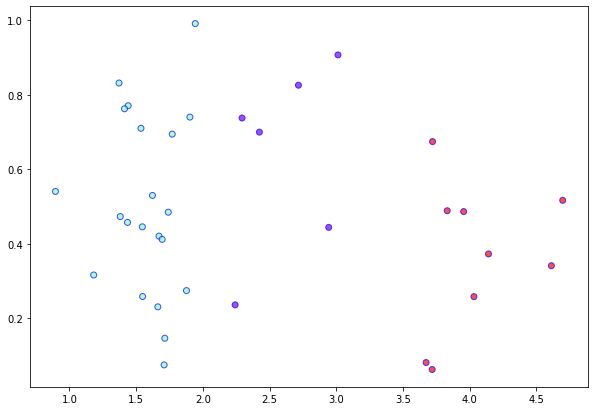

In [ ]:
figure=plt.figure(figsize=(10,7))
ax=plt.axes(projection=None)
ax.scatter(
    X_test_lda[:,0],
    X_test_lda[:,1],
    c=KMeans_Y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

In [ ]:
# accuracy in test set

total_samples = len(Y_test_code)

assert len(KMeans_Y)==total_samples

count=0
for i in range(total_samples):
   if KMeans_Y[i]==Y_test_code[i]:
     count=count+1

accuracy=count/total_samples

print('Acurracy is {}'.format(accuracy))

0.6111111111111112
